In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Duplicate key in file '/Users/shivanshbaveja/.matplotlib/matplotlibrc', line 2 ('backend : TkAgg')


In [2]:
words = open("names.txt", 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [4]:
xs = []
ys = []

# creating trigram dataset
for w in words:
    letters = ['.'] + list(w) + ['.']
    for char1, char2, char3 in zip(letters, letters[1:], letters[2:]):      
        xs.append([stoi[char1], stoi[char2]])
        ys.append(stoi[char3])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [5]:
print(xs[:10], ys[:10])

tensor([[ 0,  5],
        [ 5, 13],
        [13, 13],
        [13,  1],
        [ 0, 15],
        [15, 12],
        [12,  9],
        [ 9, 22],
        [22,  9],
        [ 9,  1]]) tensor([13, 13,  1,  0, 12,  9, 22,  9,  1,  0])


In [6]:
xs.shape

torch.Size([196113, 2])

In [7]:
# stack vectors to get one starting layer of 54 nodes
x_enc = F.one_hot(xs, num_classes=27).reshape(-1, 54).float()
x_enc.shape

torch.Size([196113, 54])

In [8]:
x_enc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
ys.shape

torch.Size([196113])

In [10]:
W = torch.randn((54, 27), requires_grad=True)

In [11]:
# training loop
NUM_ITERS = 200

n = ys.numel()
lr = 10
losses = []

for i in range(NUM_ITERS):
    # forward pass
    logits = x_enc @ W
    counts = torch.exp(logits)
    probs = counts / counts.sum(1, keepdim=True)
    
    # calculate loss
    loss = -probs[torch.arange(ys.numel()), ys].log().mean()
    losses.append(loss.item())
    
    if i % 10 == 0:
        print(loss.item())
    
    # clear gradients
    W.grad = None
    
    # backward pass
    loss.backward()
    
    # gradient update
    W.data -= lr * W.grad

4.265424728393555
3.1095354557037354
2.784071445465088
2.6319899559020996
2.5451912879943848
2.489541530609131
2.4511194229125977
2.4229629039764404
2.401376962661743
2.3842766284942627
2.3703815937042236
2.358853816986084
2.349120855331421
2.3407819271087646
2.333548069000244
2.3272080421447754
2.3216030597686768
2.316610813140869
2.3121368885040283
2.3081047534942627


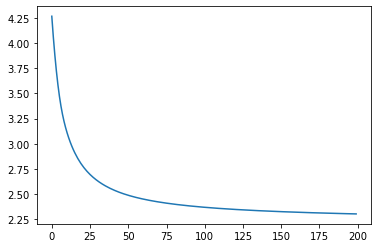

In [12]:
# plotting the losses
plt.plot(np.arange(NUM_ITERS), losses)

#### Notice that the losses converge to a value lower than the bigram model

### Sampling from the Model

In [103]:
NUM_SAMPLES = 100
idx = 0

p_second_letter = torch.tensor(([0] + [1] * 26))/26

for i in range(NUM_SAMPLES):
    out = ''
    
    state = [0, None]
    # uniform sampling of first letter in name
    state[1] = torch.multinomial(p_second_letter, num_samples=1, replacement=True).item()
    state = torch.tensor(state)
    
    out = itos[state[0].item()] + itos[state[1].item()]
        
    while True:
        x_enc_state = F.one_hot(state, num_classes=27).reshape(-1, 54).float()
        logits = x_enc_state @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
            
        next_char = torch.multinomial(probs, num_samples=1, replacement=True).item()
        
        if next_char == 0:
            print(out[1:])
            break
        
        # updating state
        state[0] = state[1]
        state[1] = next_char
        
        out += itos[next_char]

prey
qatya
een
ayle
oujto
xengeomyo
wbe
vmaynna
er
fbe
rion
maynn
paligelina
rasstanne
zahwa
srhia
areschilemarialins
kah
lonimarein
gdulen
vadariabrkzellonderayka
tynn
phev
ghanac
el
nrelaelai
ok
faizarcetona
had
von
tynnyegrantado
cahlley
narelleamela
eiya
nexarismidam
wakeh
zud
qullen
haulony
kamol
typanahamikos
vorastmay
cey
bmyana
kemgrtkaydh
mid
via
kiyusta
phaulyan
zbef
saudienn
gottra
qade
wucuz
wmleyss
gayrharlee
uilyna
reahat
jeliahric
zaylealyqnayanilae
seh
isalavdrma
mydis
loa
orivan
bevrisamirayn
ehyarireyann
jayma
viroymi
qra
wlenthie
yuh
sh
zainee
keyah
gan
erich
wande
qomnee
lamkicylo
jani
elgnftoo
ghoudano
gani
kat
elyqbzilylariangcoriy
kyonah
rana
xdusv
fikemtenileshashartynisa
ma
cadenep
syna
ebenmathir
danzan
jaminorissina
eltzusqf
rettion
uenn
raya


In [175]:
# try adding another hidden layer + biases

W1 = torch.randn((54, 27), requires_grad=True)
W2 = torch.randn((27, 27), requires_grad=True)

b1 = torch.randn(27, requires_grad=True)
b2 = torch.randn(27, requires_grad=True)


# training loop
NUM_ITERS = 350

n = ys.numel()
lr = 10
losses = []

for i in range(NUM_ITERS):
    # forward pass
    logits = (((x_enc @ W1) + b1).sigmoid() @ W2) + b2
    
    counts = torch.exp(logits)
    probs = counts / counts.sum(1, keepdim=True)
    
    # calculate loss
    loss = -probs[torch.arange(ys.numel()), ys].log().mean()
    losses.append(loss.item())
    
    if i % 10 == 0:
        print(loss.item())
    
    # clear gradients
    W1.grad = None
    W2.grad = None
    b1.grad = None
    b2.grad = None
    
    # backward pass
    loss.backward()
    
    # gradient update
    W1.data -= lr * W1.grad
    W2.data -= lr * W2.grad
    b1.data -= lr * b1.grad
    b2.data -= lr * b2.grad

7.072982311248779
2.7362725734710693
2.671983003616333
2.6193149089813232
2.5641281604766846
2.513979911804199
2.474027633666992
2.444471836090088
2.421705961227417
2.4032833576202393
2.3879482746124268
2.3749868869781494
2.3638739585876465
2.3544750213623047
2.4214365482330322
2.4022560119628906
2.3845343589782715
2.3750834465026855
2.3678133487701416
2.3616416454315186
2.35617733001709
2.3511922359466553
2.346546173095703
2.342151641845703
2.337960720062256
2.33394718170166
2.3300976753234863
2.326404333114624
2.322862386703491
2.319467782974243
2.316215991973877
2.3131041526794434
2.3101272583007812
2.307281732559204
2.3045620918273926


In [176]:
NUM_SAMPLES = 100
idx = 0

p_second_letter = torch.tensor(([0] + [1] * 26))/26

for i in range(NUM_SAMPLES):
    out = ''
    
    state = [0, None]
    # uniform sampling of first letter in name
    state[1] = torch.multinomial(p_second_letter, num_samples=1, replacement=True).item()
    state = torch.tensor(state)
    
    out = itos[state[0].item()] + itos[state[1].item()]
        
    while True:
        x_enc_state = F.one_hot(state, num_classes=27).reshape(-1, 54).float()
        logits = (((x_enc_state @ W1) + b1).sigmoid() @ W2) + b2
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
            
        next_char = torch.multinomial(probs, num_samples=1, replacement=True).item()
        
        if next_char == 0:
            print(out[1:])
            break
        
        # updating state
        state[0] = state[1]
        state[1] = next_char
        
        out += itos[next_char]

coamhii
keronfolaylaulyne
wan
resarlayvans
paylien
laubarelianfiol
qialanni
cariya
von
belsobavla
szurjaylhay
os
voson
alen
taniulana
darrihara
bron
wuriniyan
hauchyns
zik
len
lie
boniahalnavri
marlilynattanayia
wabadyyaloynoroledallean
feloanoladendayn
autsayinom
onna
nulinian
udannariosqiasarennshaneyacabylon
vauraplen
ecziomitina
ros
fadenna
tan
iluiepatan
kulieraklina
evmaiphairlasdaliaharas
illynahdialarsam
na
quhgio
zorbeannshellionah
bran
akazyanna
zaiaks
xrena
xi
yaliah
durerya
ken
uradilleyasellyn
olearilynn
wan
belliahbishes
xaamatah
dann
saic
ferreannoenaller
facenystemalyniaidarh
ginalidavie
iztie
wrronn
dieny
haisannerialtkarden
nemiraj
calywel
uryaysiya
grissidlidaloniithixtazhasen
sleyyn
th
qadyaadon
er
emandon
amighi
raivaniinnana
cadacin
colytalaylyna
jasrilaillilindavanfinalariethinheci
weniel
er
kolelickulonaiphainonkiat
nakyael
braagadestynn
hamithianah
xlerelyana
qain
nosaiialeonamia
uigan
oemariunan
ovaglarie
baenalena
jeria
chbak
evrememena
xaritoniabrenlon
quaah

### Train Test Val Split

In [15]:
n_train = np.ceil(n * 0.8).astype(int)
n_test = np.floor(n * 0.1).astype(int)
n_val = np.floor(n * 0.1).astype(int)

sampling = torch.randperm(n)

x_train = x_enc[sampling[:n_train]]
y_train = ys[sampling[:n_train]]

x_test = x_enc[sampling[:n_test]]
y_test = ys[sampling[:n_test]]

x_val = x_enc[sampling[:n_val]]
y_val = ys[sampling[:n_val]]

## Training and Evaluating Trigram and Bigram Models on Train and Test Sets

### Trigram Training

In [178]:
W = torch.randn((54,27), requires_grad=True)

# training loop
NUM_ITERS = 200

n = ys.numel()
lr = 10
losses = []

for i in range(NUM_ITERS):
    # forward pass
    logits = x_train @ W
    counts = torch.exp(logits)
    probs = counts / counts.sum(1, keepdim=True)
    
    # calculate loss
    loss = -probs[torch.arange(x_train.shape[0]), y_train].log().mean()
    losses.append(loss.item())
    
    if i % 10 == 0:
        print(loss.item())
    
    # clear gradients
    W.grad = None
    
    # backward pass
    loss.backward()
    
    # gradient update
    W.data -= lr * W.grad

4.055587291717529
3.0661001205444336
2.786468505859375
2.64180850982666
2.555030107498169
2.4989984035491943
2.460557460784912
2.4326226711273193
2.411245584487915
2.3941941261291504
2.3801677227020264
2.3683652877807617
2.3582639694213867
2.34950590133667
2.34183406829834
2.3350589275360107
2.3290340900421143
2.323646068572998
2.318802833557129
2.314429998397827


### Evaluate on Test Set

In [174]:
y_pred = torch.argmax(x_test @ W, dim=1)
acc = sum(y_pred == y_test)/len(y_pred)
acc

tensor(0.2872)

### Regularization Tuning

In [29]:
def reg_tune_training(reg):
    W = torch.randn((54,27), requires_grad=True)

    # training loop
    NUM_ITERS = 200

    n = ys.numel()
    lr = 10
    losses = []

    for i in range(NUM_ITERS):
        # forward pass
        logits = x_train @ W
        counts = torch.exp(logits)
        probs = counts / counts.sum(1, keepdim=True)

        # calculate loss
        loss = -probs[torch.arange(x_train.shape[0]), y_train].log().mean() + reg * (W **2).mean()
        losses.append(loss.item())

        # clear gradients
        W.grad = None

        # backward pass
        loss.backward()

        # gradient update
        W.data -= lr * W.grad
        
    # calculate predictions
    y_pred = torch.argmax(x_test @ W, dim=1)
    acc = sum(y_pred == y_test)/len(y_pred)
    
    return acc, losses

In [57]:
regs = [0.01, 0.1, 1, 10, 100]
accuracies, losses = [], []

for reg in regs:
    acc, loss = reg_tune_training(reg)
    accuracies.append(acc)
    losses.append(loss)

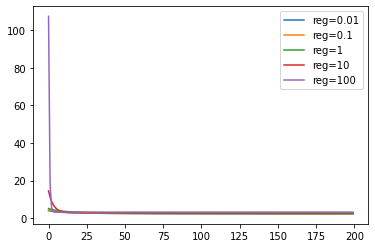

In [61]:
for i in range(len(regs)):
    plt.plot(np.arange(len(losses[i])), losses[i], label=f"reg={regs[i]}")
plt.legend()
plt.show()

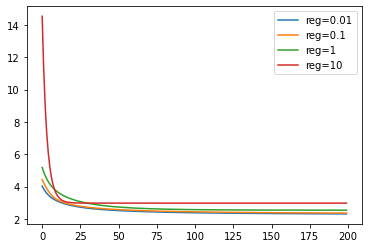

In [62]:
for i in range(len(regs) - 1):
    plt.plot(np.arange(len(losses[i])), losses[i], label=f"reg={regs[i]}")
plt.legend()
plt.show()

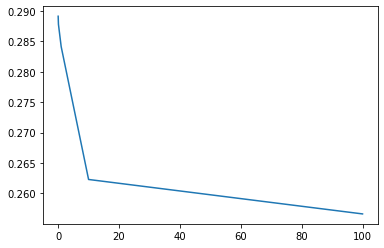

In [63]:
plt.plot(regs, accuracies)

Notice that the losses converge to a higher value the higher the regularization is. This makes sense since we're adding a larger positive value to the loss. Further, notice that we also obtain the best accuracy with the smallest regularization.

### Training Without One-Hot Encoding (Using Indexing)

In [64]:
xs.shape

torch.Size([196113, 2])

In [65]:
x_enc.shape

torch.Size([196113, 54])

In [74]:
W[xs].reshape(-1, 54).shape

torch.Size([196113, 54])

In [85]:
ys.shape

torch.Size([196113])

In [100]:
(27 * xs[:, 0] + xs[:, 1]).max()

tensor(728)

### Also changing to CrossEntropyLoss

In [103]:
# training loop
NUM_ITERS = 200

W = torch.randn((729, 27), requires_grad=True)
cel = torch.nn.CrossEntropyLoss()

n = ys.numel()
lr = 100
losses = []

for i in range(NUM_ITERS):
    # forward pass
    indices = 27 * xs[:, 0] + xs[:, 1]
    logits = W[indices]
    loss = cel(logits, ys)
    losses.append(loss.item())
    
    if i % 10 == 0:
        print(loss.item())
    
    # clear gradients
    W.grad = None
    
    # backward pass
    loss.backward()
    
    # gradient update
    W.data -= lr * W.grad

3.698413610458374
2.905913829803467
2.6622345447540283
2.537160873413086
2.457545757293701
2.4022397994995117
2.3613643646240234
2.329698324203491
2.304333448410034
2.2835099697113037
2.2660818099975586
2.251264810562134
2.2385029792785645
2.2273900508880615
2.2176241874694824
2.2089738845825195
2.201260566711426
2.1943416595458984
2.1881017684936523
2.1824474334716797


Notice here that we converge to a much lower loss, likely because we have more parameters in our model. Notice that structuring our inputs this way also makes it easier for the model to learn the correct dependencies. When we have a 54 node input layer, with consecutive blocks of 27 representing the initial two states, it relates the states "ab" and the states "ac" since they share a node. For this application, it is both intuitively and empirically better to treat these states independently, which the extra nodes in our 729 input node model allow us to express. This allows to not learn faulty interdependencies which add noise to our model.

In [106]:
NUM_SAMPLES = 100
idx = 0

p_second_letter = torch.tensor(([0] + [1] * 26))/26

for i in range(NUM_SAMPLES):
    out = ''
    
    state = [0, None]
    # uniform sampling of first letter in name
    state[1] = torch.multinomial(p_second_letter, num_samples=1, replacement=True).item()
    state = torch.tensor(state)
    
    out = itos[state[0].item()] + itos[state[1].item()]
        
    while True:
        index = 27 * state[0] + state[1]
        logits = W[index]
        counts = logits.exp()
        probs = counts / counts.sum()
        
        next_char = torch.multinomial(probs, num_samples=1, replacement=True).item()
        
        if next_char == 0:
            print(out[1:])
            break
        
        # updating state
        state[0] = state[1]
        state[1] = next_char
        
        out += itos[next_char]

te
palowpttentellzpp
quel
ja
gaquimesia
pozsofnyah
haiduann
gl
pawa
xashi
ga
cana
yuix
elievereyson
kel
p
breighnitblah
dayah
lciyanalydilo
faqmggjkyri
izoj
baurwwcwwmberah
maklynnvwjwssamzwljh
dabelrne
jera
bria
visona
imirenn
dwaizlisav
dus
lya
ustef
jonala
qujcarea
ubqzvzdmaydesana
carenn
omiewdmjwtuzclaymacelangen
jacxylah
tvubwdresnziren
vasntevaqbwhkdxsimiktan
da
mari
ommyvon
qokqod
wookhauruccxaadeseana
valoazelariel
tqo
taniyah
trilacali
phhlan
ge
casne
ha
edmon
kaaley
slanie
ethdvwbbbsiel
irctlmkshala
ojia
isennaidexnwbppkvboethir
gawxymxzulp
brethoekocobiton
tummifemimtmly
ya
dle
kaistirabdgpgraele
royonsgel
im
rotjymq
jjhon
maeljittxrz
vyim
mah
denelez
ma
bry
wacpby
gqyptbsdjbqgdywncy
ishtaus
lie
larum
osemor
elynnis
rudqfre
zah
chalance
finnika
zallezhwana
rand
mavetteut
ux
yuwa
nalaguwajer
pas
quli
cef
yahadem
qfa
hadevmgh
predah
